## Laboratoire 2
**Equipe 1** 



**Membres:**


## Introduction

 Pour ce laboratoire, nous devons choisir 8 classes pour créer un ensemble d'images qui pourront être reconnu grâce aux notions que nous avons apprisent en classe.
 Pour ce faire, nous utiliserons Jupyter Notebook afin de séparer clairement chacune des étapes que nous deverons accomplir.
 

## Importation des librairies nécéssaires

Les librairies qui nous seront nécéssaire pour le traitement des images sont les suivantes :


In [806]:
from pathlib import Path
import matplotlib.pyplot as plt
import pandas as pd
import cv2
import numpy as np
import imutils
import random
import os
import pickle
from tqdm.notebook import tqdm
from glob import glob
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn import preprocessing
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, mean_squared_error, f1_score
from sklearn.neural_network import MLPClassifier

## Augmentation des données

## Choix du Dataset pour l'ensemble B

Voici notre choix d'images pour l'ensemble B. Cet ensemble est constitué de 8 symboles : 

In [807]:
# Define the base data directory path
data_dir = Path.cwd() / "EnsembleB_H2020"

# A list of string with all the categories/labels in your database, i.e., each class subfolder name
CLASSES = [
    {
        "LABEL": "Cercle2", 
        "GROUP": 0,
        "PATH": os.path.join(data_dir, 'Cercles', 'Cercle2')
    },
    {
        "LABEL": "Cercle3", 
        "GROUP": 1,
        "PATH": os.path.join(data_dir, 'Cercles', 'Cercle3')
    },
    {
        "LABEL": "Diamant2",
        "GROUP": 2,
        "PATH": os.path.join(data_dir, 'Diamants', 'Diamant2')
    },
    {
        "LABEL":"Diamant3", 
        "GROUP": 3,
        "PATH": os.path.join(data_dir, 'Diamants', 'Diamant3')
    },
    {
        "LABEL":"Hexagone2", 
        "GROUP": 4,
        "PATH": os.path.join(data_dir, 'Hexagones', 'Hexagone2')
    },
    {
        "LABEL":"Hexagone3", 
        "GROUP": 5,
        "PATH": os.path.join(data_dir, 'Hexagones', 'Hexagone3')
    },
    {
        "LABEL":"Triangle2", 
        "GROUP": 6,
        "PATH": os.path.join(data_dir, 'Triangles', 'Triangle2')
    },
    {
        "LABEL":"Triangle3", 
        "GROUP": 7,
        "PATH": os.path.join(data_dir, 'Triangles', 'Triangle3')
    }
]

In [808]:
imageSize = (160, 160)

dataSet = []

# Read all the files and append to dataset
for CLASS in CLASSES:
    print(f"=> Reading files from class {CLASS['LABEL']}")
    for image in tqdm(glob(os.path.join(CLASS["PATH"], '*'))):
        # Read the image in grayscale
        gray = cv2.imread(image, cv2.IMREAD_GRAYSCALE)
        # Resize the image
        gray = cv2.resize(gray, imageSize)
        
        # Calculate contours
        blurred = cv2.GaussianBlur(gray, (5,5), 0)
        thresh = cv2.threshold(blurred, 150, 255, cv2.THRESH_BINARY)[1]
        contours, hierarchy = cv2.findContours(thresh.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        
        polygons = []
        
        # Save the polygons
        for contour in contours:
            perimeter = cv2.arcLength(contour, True)
            approximation = cv2.approxPolyDP(contour, 0.02 * perimeter, True)
            polygons.append(len(approximation))
        
        feature = [0 for i in range(16)]
        
        # Create the feature vector from polygons
        for polygon in polygons:
            feature[polygon] += 1
        
        # Create a data variable to add to dataSet
        data = {
            'image': gray,
            'label': CLASS['GROUP'],
            'polygons': polygons,
            'feature': feature
        }
        
        # Append data to dataSet
        dataSet.append(data)   

=> Reading files from class Cercle2


  0%|          | 0/184 [00:00<?, ?it/s]

=> Reading files from class Cercle3


  0%|          | 0/175 [00:00<?, ?it/s]

=> Reading files from class Diamant2


  0%|          | 0/130 [00:00<?, ?it/s]

=> Reading files from class Diamant3


  0%|          | 0/145 [00:00<?, ?it/s]

=> Reading files from class Hexagone2


  0%|          | 0/147 [00:00<?, ?it/s]

=> Reading files from class Hexagone3


  0%|          | 0/129 [00:00<?, ?it/s]

=> Reading files from class Triangle2


  0%|          | 0/164 [00:00<?, ?it/s]

=> Reading files from class Triangle3


  0%|          | 0/128 [00:00<?, ?it/s]

In [810]:
# Shuffles the images
random.shuffle(dataSet)

# create the X and y from DataSet
X = np.array([data['feature'] for data in dataSet])
y = np.array([data['label'] for data in dataSet])

# Creating the files containing all the information about your model and saving them to the disk
pickle_out = open("X.pickle", "wb")
pickle.dump(X, pickle_out)
pickle_out.close()

pickle_out = open("y.pickle", "wb")
pickle.dump(y, pickle_out)
pickle_out.close()

## Machine learning training

In [811]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=84)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=84)

In [812]:
scaler = MinMaxScaler(feature_range=(0,1))
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)
X_val = scaler.fit_transform(X_val)

In [813]:
X_train = X_train.flatten()
X_test = X_test.flatten()
X_val = X_val.flatten()

In [814]:
X_train = X_train.reshape(len(y_train), len(X[0]))
X_test = X_test.reshape(len(y_test),len(X[0]))
X_val = X_val.reshape(len(y_val), len(X[0]))

## Réseau neuronal

In [815]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def sigmoid_prime(z):
    o = sigmoid(z)
    return o*(1-o)

In [816]:
class NeuralNetwork:

    def __init__(self, n_classes, n_features, n_hidden_units=15, epochs=300,
                 learning_rate=0.01, n_batches=1):
        self.n_classes = n_classes
        self.n_features = n_features
        self.n_hidden_units = n_hidden_units
        self.n_batches = n_batches
        self.w1, self.w2 = self.weights()
        self.learning_rate = learning_rate
        self.epochs = epochs
        
    def error(self, y, output):
        error = -np.sum(y*np.log(output))
        return 0.5 * np.mean(error)

    def weights(self):
        w1 = np.random.rand(self.n_hidden_units, self.n_features)
        w2 = np.random.rand(self.n_classes, self.n_hidden_units)
        return w1, w2

    def forward(self, X):
        z1 = np.dot(self.w1,X.T)
        hidden_output = sigmoid(z1)
        z2 = np.dot(self.w2,hidden_output)
        final_output = sigmoid(z2)
        return z1, hidden_output, z2, final_output

    def backward(self, X, z1, hidden_output, final_output, y):
        output_error = final_output - y
        output_delta = self.w2.T.dot(output_error) * sigmoid_prime(z1)
        grad1 = output_delta.dot(X)
        grad2 = output_error.dot(hidden_output.T)
        return grad1, grad2

    def backprop_step(self, X, y):
        z1, hidden_output, z2, final_output = self.forward(X)
        y = y.T
        grad1, grad2 = self.backward(X, z1, hidden_output, final_output, y)
        error = self.error(y, final_output)
        return error, grad1, grad2

    def fit(self, X, y):
        self.error_ = []
        lb = preprocessing.LabelBinarizer()
        y = lb.fit_transform(y)

        X_batches = np.array_split(X, self.n_batches)
        y_batches = np.array_split(y, self.n_batches)

        for i in range(self.epochs):
            epoch_errors = []
            for Xi, yi in zip(X_batches, y_batches):
                error, grad1, grad2 = self.backprop_step(Xi, yi)
                epoch_errors.append(error)
                self.w1 -= (self.learning_rate * grad1)
                self.w2 -= (self.learning_rate * grad2)
            self.error_.append(np.mean(epoch_errors))
            print(i, np.mean(epoch_errors))
        return self

    def predict(self, X):
        z1, hidden_output, z2, final_output = self.forward(X)
        return np.argmax(z2.T, 1)

    def score(self, X, y):
        y_hat = self.predict(X)
        return np.sum(y == y_hat, axis=0) / float(X.shape[0])

In [817]:
nn = NeuralNetwork(
    n_classes=8, 
    n_features=len(X[0]),
    n_hidden_units=50,
    epochs=3000,
    learning_rate=0.01,
    n_batches=30,
).fit(X_train, y_train);

0 22.84266602859217
1 26.985301296138363
2 26.83625509079008
3 26.68417843726048
4 26.5269000218978
5 26.36266340266886
6 26.190158165450466
7 26.008570828554095
8 25.81764269138053
9 25.617718802485857
10 25.409770141475175
11 25.195371685086663
12 24.976623840514215
13 24.75601431157965
14 24.536230464833928
15 24.31994525874369
16 24.10960828144897
17 23.90727384059487
18 23.71448972774811
19 23.532256137223516
20 23.361049306882183
21 23.200893470458485
22 23.051460021578503
23 22.912173978631643
24 22.782312732240616
25 22.661088146702923
26 22.547708531158538
27 22.441420913483295
28 22.341536328164544
29 22.247441778090227
30 22.158602586884765
31 22.074558419291883
32 21.994915602159995
33 21.91933770918642
34 21.847535774828483
35 21.779259015662788
36 21.714286566276012
37 21.65242046966966
38 21.593479980529484
39 21.537297123977496
40 21.483713384997596
41 21.43257737015518
42 21.383743272379338
43 21.337069973285498
44 21.292420630053222
45 21.24966261133112
46 21.20866766

382 17.699495366504323
383 17.69314050347217
384 17.686765853530336
385 17.680371380035442
386 17.673957054722813
387 17.66752285776848
388 17.66106877784684
389 17.65459481218377
390 17.64810096660512
391 17.641587255580344
392 17.635053702261107
393 17.628500338514844
394 17.62192720495298
395 17.61533435095372
396 17.608721834679326
397 17.602089723087758
398 17.595438091938455
399 17.58876702579232
400 17.58207661800567
401 17.57536697071814
402 17.56863819483444
403 17.561890409999915
404 17.555123744569798
405 17.54833833557215
406 17.541534328664486
407 17.53471187808392
408 17.52787114659099
409 17.521012305406998
410 17.514135534144966
411 17.507241020734195
412 17.500328961338415
413 17.4933995602676
414 17.48645302988351
415 17.47948959049893
416 17.472509470270804
417 17.46551290508719
418 17.458500138448258
419 17.451471421341306
420 17.444427012110058
421 17.437367176318155
422 17.43029218660717
423 17.423202322549127
424 17.416097870493765
425 17.40897912341063
426 17.40

755 15.497945713273227
756 15.493675087667844
757 15.489407142497372
758 15.485141844120761
759 15.480879159425156
760 15.476619055822594
761 15.472361501246667
762 15.468106464149189
763 15.463853913496823
764 15.459603818767668
765 15.45535614994784
766 15.451110877528057
767 15.446867972500154
768 15.442627406353612
769 15.438389151072075
770 15.434153179129806
771 15.429919463488176
772 15.425687977592107
773 15.421458695366498
774 15.41723159121265
775 15.413006640004673
776 15.40878381708586
777 15.404563098265077
778 15.400344459813121
779 15.396127878459065
780 15.391913331386608
781 15.387700796230392
782 15.383490251072342
783 15.379281674437953
784 15.375075045292608
785 15.370870343037865
786 15.366667547507745
787 15.362466638965028
788 15.358267598097509
789 15.354070406014282
790 15.349875044242005
791 15.345681494721168
792 15.34148973980235
793 15.337299762242486
794 15.333111545201119
795 15.328925072236661
796 15.324740327302658
797 15.32055729474404
798 15.316375959

1133 14.014182087973422
1134 14.010677437933209
1135 14.00717537693215
1136 14.003675904222199
1137 14.00017901901685
1138 13.996684720490878
1139 13.993193007780064
1140 13.989703879980956
1141 13.986217336150547
1142 13.982733375306026
1143 13.979251996424477
1144 13.975773198442543
1145 13.972296980256179
1146 13.968823340720274
1147 13.965352278648371
1148 13.961883792812323
1149 13.958417881941976
1150 13.954954544724805
1151 13.951493779805606
1152 13.94803558578613
1153 13.944579961224743
1154 13.941126904636077
1155 13.937676414490689
1156 13.934228489214671
1157 13.930783127189347
1158 13.92734032675088
1159 13.923900086189928
1160 13.920462403751293
1161 13.917027277633558
1162 13.913594705988753
1163 13.910164686921993
1164 13.906737218491113
1165 13.903312298706359
1166 13.899889925530012
1167 13.896470096876088
1168 13.893052810609964
1169 13.889638064548079
1170 13.886225856457598
1171 13.882816184056107
1172 13.879409045011284
1173 13.876004436940613
1174 13.872602357411

1519 12.814490548291761
1520 12.811663500893468
1521 12.808837591643726
1522 12.806012821483668
1523 12.803189191376422
1524 12.800366702306768
1525 12.79754535528076
1526 12.794725151325402
1527 12.791906091488245
1528 12.789088176837089
1529 12.786271408459577
1530 12.783455787462856
1531 12.78064131497323
1532 12.777827992135803
1533 12.77501582011409
1534 12.772204800089717
1535 12.769394933262026
1536 12.766586220847708
1537 12.763778664080496
1538 12.760972264210759
1539 12.758167022505182
1540 12.755362940246401
1541 12.75256001873263
1542 12.749758259277339
1543 12.74695766320887
1544 12.744158231870118
1545 12.741359966618138
1546 12.73856286882383
1547 12.735766939871558
1548 12.732972181158825
1549 12.730178594095895
1550 12.727386180105468
1551 12.724594940622314
1552 12.721804877092934
1553 12.719015990975214
1554 12.71622828373806
1555 12.713441756861064
1556 12.710656411834176
1557 12.707872250157317
1558 12.705089273340088
1559 12.702307482901357
1560 12.699526880368994

1882 11.870562005457037
1883 11.86818052087337
1884 11.86579996262531
1885 11.863420327096767
1886 11.861041610671036
1887 11.858663809731
1888 11.85628692065931
1889 11.853910939838608
1890 11.851535863651721
1891 11.849161688481844
1892 11.846788410712753
1893 11.84441602672898
1894 11.842044532916022
1895 11.839673925660493
1896 11.837304201350356
1897 11.834935356375068
1898 11.83256738712578
1899 11.830200289995515
1900 11.827834061379333
1901 11.825468697674516
1902 11.823104195280733
1903 11.820740550600222
1904 11.818377760037945
1905 11.816015820001736
1906 11.813654726902506
1907 11.811294477154371
1908 11.808935067174819
1909 11.806576493384851
1910 11.804218752209165
1911 11.80186184007627
1912 11.799505753418666
1913 11.797150488672951
1914 11.794796042279996
1915 11.792442410685087
1916 11.79008959033803
1917 11.787737577693301
1918 11.785386369210208
1919 11.783035961352963
1920 11.780686350590857
1921 11.778337533398362
1922 11.775989506255257
1923 11.773642265646751
19

2236 11.062125805604438
2237 11.059883883838241
2238 11.057641930937056
2239 11.055399945332988
2240 11.053157925471531
2241 11.050915869811686
2242 11.048673776826009
2243 11.04643164500075
2244 11.044189472835885
2245 11.041947258845223
2246 11.0397050015565
2247 11.037462699511435
2248 11.03522035126583
2249 11.032977955389637
2250 11.03073551046705
2251 11.02849301509655
2252 11.026250467891028
2253 11.024007867477822
2254 11.021765212498785
2255 11.019522501610403
2256 11.017279733483813
2257 11.015036906804905
2258 11.012794020274365
2259 11.010551072607768
2260 11.008308062535633
2261 11.006064988803464
2262 11.003821850171851
2263 11.001578645416497
2264 10.999335373328305
2265 10.997092032713416
2266 10.99484862239326
2267 10.992605141204642
2268 10.990361587999773
2269 10.988117961646315
2270 10.985874261027451
2271 10.983630485041925
2272 10.981386632604087
2273 10.979142702643935
2274 10.976898694107188
2275 10.974654605955278
2276 10.972410437165442
2277 10.970166186730733

2612 10.214586845437392
2613 10.212336813946745
2614 10.210086959882023
2615 10.20783728482163
2616 10.205587790348824
2617 10.203338478051721
2618 10.201089349523356
2619 10.19884040636171
2620 10.196591650169761
2621 10.1943430825555
2622 10.192094705131996
2623 10.189846519517413
2624 10.18759852733505
2625 10.185350730213385
2626 10.183103129786083
2627 10.180855727692066
2628 10.178608525575509
2629 10.176361525085898
2630 10.174114727878045
2631 10.171868135612119
2632 10.169621749953677
2633 10.1673755725737
2634 10.16512960514859
2635 10.162883849360231
2636 10.160638306895981
2637 10.158392979448717
2638 10.156147868716861
2639 10.153902976404355
2640 10.151658304220739
2641 10.14941385388113
2642 10.147169627106251
2643 10.144925625622445
2644 10.142681851161694
2645 10.140438305461608
2646 10.138194990265486
2647 10.135951907322262
2648 10.133709058386554
2649 10.131466445218674
2650 10.129224069584598
2651 10.126981933256017
2652 10.124740038010298
2653 10.122498385630507
2

2988 9.397250856068803
2989 9.39519291546003
2990 9.393135732335056
2991 9.391079307291134
2992 9.389023640922655
2993 9.386968733821144
2994 9.384914586575347
2995 9.382861199771234
2996 9.380808573992072
2997 9.378756709818454
2998 9.376705607828335
2999 9.374655268597072


In [818]:
print('Train Accuracy: %.2f%%' % (nn.score(X_train, y_train) * 100))

Train Accuracy: 77.60%


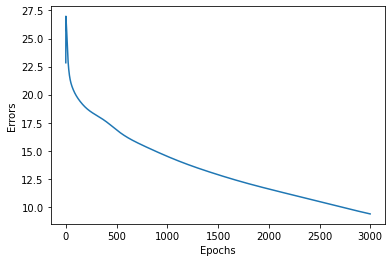

In [819]:
def plot_error(model):
    plt.plot(range(len(model.error_)), model.error_)
    plt.xlabel('Epochs')
    plt.ylabel('Errors')
    plt.show()
    
plot_error(nn)

In [820]:
y_train_prediction = nn.predict(X_train)
y_test_prediction = nn.predict(X_test)
y_prediction = nn.predict(X_val)

### Matrice de confusion ensemble "train"

In [821]:
print(confusion_matrix(y_train,y_train_prediction))
print(classification_report(y_train,y_train_prediction))

[[101   5   0   2   1   2   1   0]
 [  4  96   4   1   0   5   0   1]
 [  8   0  57   4   8   2   2   4]
 [  8   1   1  60   2   5   0  15]
 [ 10   5   0   1  71   5   1   3]
 [  3   1   0   3   4  68   1   0]
 [  4   0   9   0   5   0  81   7]
 [  2   0   2   7   3   5   5  62]]
              precision    recall  f1-score   support

           0       0.72      0.90      0.80       112
           1       0.89      0.86      0.88       111
           2       0.78      0.67      0.72        85
           3       0.77      0.65      0.71        92
           4       0.76      0.74      0.75        96
           5       0.74      0.85      0.79        80
           6       0.89      0.76      0.82       106
           7       0.67      0.72      0.70        86

    accuracy                           0.78       768
   macro avg       0.78      0.77      0.77       768
weighted avg       0.78      0.78      0.78       768



### Matrice de confusion ensemble "test"

In [822]:
print(confusion_matrix(y_test,y_test_prediction))
print(classification_report(y_test,y_test_prediction))

[[14  7  0 18  0  2  1  0]
 [ 2 16  0  7  2  2  3  0]
 [ 5  0  0 16  1  2  0  2]
 [ 0  4  1 18  1  1  0  1]
 [ 1  2  1 16  7  5  2  0]
 [ 1  3  0  6  1 15  1  0]
 [ 4  0  2 10  0  0 14  3]
 [ 0  0  0  9  0  1  3  8]]
              precision    recall  f1-score   support

           0       0.52      0.33      0.41        42
           1       0.50      0.50      0.50        32
           2       0.00      0.00      0.00        26
           3       0.18      0.69      0.29        26
           4       0.58      0.21      0.30        34
           5       0.54      0.56      0.55        27
           6       0.58      0.42      0.49        33
           7       0.57      0.38      0.46        21

    accuracy                           0.38       241
   macro avg       0.43      0.39      0.37       241
weighted avg       0.45      0.38      0.38       241



### Matrice de confusion ensemble "Val"

In [823]:
print(confusion_matrix(y_val,y_prediction))
print(classification_report(y_val,y_prediction))

[[ 8 18  0  2  0  1  1  0]
 [ 0 29  0  2  0  0  1  0]
 [ 0  2  0 10  1  4  1  1]
 [ 0  6  0 16  1  1  2  1]
 [ 2  2  2  2  2  7  0  0]
 [ 0 14  1  3  1  3  0  0]
 [ 5  0  2  0  0  0 14  4]
 [ 0  2  2  7  3  1  1  5]]
              precision    recall  f1-score   support

           0       0.53      0.27      0.36        30
           1       0.40      0.91      0.55        32
           2       0.00      0.00      0.00        19
           3       0.38      0.59      0.46        27
           4       0.25      0.12      0.16        17
           5       0.18      0.14      0.15        22
           6       0.70      0.56      0.62        25
           7       0.45      0.24      0.31        21

    accuracy                           0.40       193
   macro avg       0.36      0.35      0.33       193
weighted avg       0.38      0.40      0.36       193



## Support Vector Machine (SVM lineair)

In [824]:
svc = SVC(cache_size=1500)
parameter = {'kernel': ['linear'], 'C': [0.001, 0.1, 1, 10], 'class_weight': ['balanced'], 'gamma': ['scale']}
classifier = GridSearchCV(svc, param_grid = parameter, cv = 10, n_jobs = 5, scoring = 'accuracy', verbose=4)
classifier.fit(X_train, y_train)
print("LINEAR : The best hyperparameters are %s with a score of %0.2f" % (classifier.best_params_, classifier.best_score_))

Fitting 10 folds for each of 4 candidates, totalling 40 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.0s


LINEAR : The best hyperparameters are {'C': 10, 'class_weight': 'balanced', 'gamma': 'scale', 'kernel': 'linear'} with a score of 0.56


[Parallel(n_jobs=5)]: Done  40 out of  40 | elapsed:    0.1s finished


Nous avons constaté qu'augmenter la grosseur de la cache ne changeait pas nos résultats, alors nous l'avons gardé à 1500.

In [825]:
SVMaccuracy = pd.DataFrame(classifier.cv_results_['mean_test_score'], index = [x['C'] for x  in classifier.cv_results_['params']], columns = ['SVM accuracy'])
print(SVMaccuracy)

        SVM accuracy
0.001       0.114559
0.100       0.304853
1.000       0.472864
10.000      0.560082


## K-Nearest Neighbor (KNN)

In [826]:
# K-Nearest Neighbor 
def KNN_model (X_train, X_test, y_train, y_test, weights):
    
    KNN_accuracy_uniform = []
    KNN_f1_uniform = []
    
    KNNParams = [3,5,10]

    for neighbors in KNNParams:

        model = KNeighborsClassifier(n_neighbors = neighbors, weights = weights)
        KNNmodel = model.fit(X_train, y_train)
        y_prediction = KNNmodel.predict(X_test)
        
        accuracy = accuracy_score(y_test, y_prediction)
        f1score = f1_score(y_test, y_prediction, average = 'weighted') 

        KNN_accuracy_uniform.append(accuracy)
        KNN_f1_uniform.append(f1score)
        
        # F1 Score
        print("F1 score : KNN")
        print(f1_score(y_test, y_prediction, average = 'weighted'))
        
        # Accuracy Score
        print("Accuracy score : KNN avec k = " + str(neighbors) + " et poid = " + weights)
        print(KNNmodel.score(X_test, y_test))
        
        clf  = KNeighborsClassifier(n_neighbors = neighbors, weights = 'distance')
        
        ## KNN - Cross-validation
        print("Cross-validation")
        KNN_scores = cross_val_score(clf , X, y, cv = 10)
        print(sum(KNN_scores) / 10)
        print('\n')

In [828]:
KNN_model(X_train, X_test, y_train, y_test, 'uniform')
KNN_model(X_train, X_test, y_train, y_test, 'distance')

F1 score : KNN
0.29592694279325216
Accuracy score : KNN avec k = 3 et poid = uniform
0.3029045643153527
Cross-validation
0.6248209366391185


F1 score : KNN
0.29661008799134647
Accuracy score : KNN avec k = 5 et poid = uniform
0.3029045643153527
Cross-validation
0.6414876033057851


F1 score : KNN
0.3658977209375383
Accuracy score : KNN avec k = 10 et poid = uniform
0.36929460580912865
Cross-validation
0.6614807162534435


F1 score : KNN
0.34086031067691
Accuracy score : KNN avec k = 3 et poid = distance
0.34024896265560167
Cross-validation
0.6248209366391185


F1 score : KNN
0.32786828893544007
Accuracy score : KNN avec k = 5 et poid = distance
0.33195020746887965
Cross-validation
0.6414876033057851


F1 score : KNN
0.39536690429080523
Accuracy score : KNN avec k = 10 et poid = distance
0.3900414937759336
Cross-validation
0.6614807162534435




## Réseaux de neurones (RN)

In [829]:
mlp = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5, 2), random_state=1)
mlp.fit(X, y)

c:\users\kevin\appdata\local\programs\python\python37\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


MLPClassifier(alpha=1e-05, hidden_layer_sizes=(5, 2), random_state=1,
              solver='lbfgs')

In [830]:
y_test_prediction = mlp.predict(X_test)
y_train_prediction = mlp.predict(X_train)
y_prediction = mlp.predict(X_val)

### Matrice de confusion ensemble "train"

In [831]:
print(confusion_matrix(y_train,y_train_prediction))
print(classification_report(y_train,y_train_prediction))

[[ 8  0  0 18 86  0  0  0]
 [17  0  0  3 91  0  0  0]
 [ 0  0  0  4 78  0  3  0]
 [ 8  0  0 11 72  0  1  0]
 [ 4  0  0  4 88  0  0  0]
 [ 5  0  0  1 74  0  0  0]
 [13  0  0 47 29  0 17  0]
 [ 6  0  0 21 44  0 15  0]]
              precision    recall  f1-score   support

           0       0.13      0.07      0.09       112
           1       0.00      0.00      0.00       111
           2       0.00      0.00      0.00        85
           3       0.10      0.12      0.11        92
           4       0.16      0.92      0.27        96
           5       0.00      0.00      0.00        80
           6       0.47      0.16      0.24       106
           7       0.00      0.00      0.00        86

    accuracy                           0.16       768
   macro avg       0.11      0.16      0.09       768
weighted avg       0.12      0.16      0.09       768



c:\users\kevin\appdata\local\programs\python\python37\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Matrice de confusion ensemble "test"

In [832]:
print(confusion_matrix(y_test,y_test_prediction))
print(classification_report(y_test,y_test_prediction))

[[ 4  0  0  3 33  0  2  0]
 [ 7  0  0  0 23  0  2  0]
 [ 1  0  0  0 24  0  1  0]
 [ 5  0  0  1 20  0  0  0]
 [ 3  0  0  1 30  0  0  0]
 [ 5  0  0  1 21  0  0  0]
 [ 3  0  0  4  7  0 19  0]
 [ 0  0  0  0 13  0  8  0]]
              precision    recall  f1-score   support

           0       0.14      0.10      0.11        42
           1       0.00      0.00      0.00        32
           2       0.00      0.00      0.00        26
           3       0.10      0.04      0.06        26
           4       0.18      0.88      0.29        34
           5       0.00      0.00      0.00        27
           6       0.59      0.58      0.58        33
           7       0.00      0.00      0.00        21

    accuracy                           0.22       241
   macro avg       0.13      0.20      0.13       241
weighted avg       0.14      0.22      0.15       241



## Conclusion

yo